<a href="https://colab.research.google.com/github/iqbalhanif/Spatial-Machine-Learning/blob/main/Spatial_Machine_Learning_in_R_(Landslide_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##mount google drive agar bisa connect
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##cara agar bisa menggunakan R di colab
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 1. Membuat Data

In [ ]:
##download package yang tidak bisa di install dengan cara biasa (di colab)
!sudo apt-get update
!sudo apt-get install libgdal-dev libproj-dev 
!sudo apt-get update
!sudo apt install libgeos++dev

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 1s (241 kB/s)
Reading package lists... Done
Reading package lists... Done
Building

In [ ]:
##install dan load package yang sudah didownload tadi
%%R
install.packages("rgdal")
install.packages("rgeos")
library("rgdal") ##input/output file spatial
library("rgeos") ##maniplasi data spatial

In [ ]:
##install package2 yang bisa diinstall dengan cata biasa
%%R
install.packages("DMwR")
install.packages("caret")
install.packages("snow")
install.packages("maptools")
install.packages("randomForest")
install.packages("e1071")
library(devtools)
devtools:::install_github("gearslaboratory/gdalUtils")

In [ ]:
##load package yang sudah diinstall tadi
%%R
library(raster) ##bekerja dengan data raster
library(sp) ##bekerja dengan data vektor
library(dplyr) ##data processing/manipulation
library(DMwR) ##data processing/manipulation
library(caret) ##machine learning
library(snow) ##paralel computation untuk memproses komputasi
library(maptools) ##manipulasi data spasial
library(gdalUtils) ##manipulasi data spasial
library(randomForest) ##machine learning (random forest)
library(e1071)

In [ ]:
##create non-landslide data, karena data awal hanya ada landslide data (data tanah longsor)
##load slope yang kurang 10 derajat kemudian dianggap non-landslide
%%R
setwd("/content/drive/MyDrive/Machine Learning with R/")
slope <- raster("slope.tif")
reclass_df <- c(0, 10, 1, 10, Inf, NA) ##membuat objek yang isinya adalah vektor, 0-10 nilainya 1, 10 - inf nilainya NA
reclass_m <- matrix(reclass_df, ncol = 3, byrow = TRUE)
reclass_m 

     [,1] [,2] [,3]
[1,]    0   10    1
[2,]   10  Inf   NA


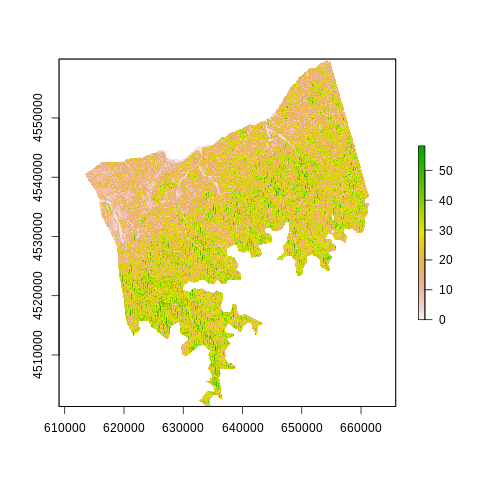

In [ ]:
##cek data slope
%%R
plot(slope)

In [ ]:
##classify data slope sesuai aturan tadi (matrix reclass)
##kemudian simpan datanya jadi poligon slope_no_ls
%%R
slope_classified <- reclassify(slope, reclass_m)
r.to.poly<-rasterToPolygons(slope_classified, dissolve = T) ##dissolve semuanya jadi satu fitur
writeOGR(r.to.poly, ".", "slope_no_ls", driver="ESRI Shapefile")

R[write to console]: Error in writeOGR(r.to.poly, ".", "slope_no_ls", driver = "ESRI Shapefile") : 
  layer exists, use a new layer name
Calls: <Anonymous> -> <Anonymous> -> withVisible -> writeOGR




Error in writeOGR(r.to.poly, ".", "slope_no_ls", driver = "ESRI Shapefile") : 
  layer exists, use a new layer name
Calls: <Anonymous> -> <Anonymous> -> withVisible -> writeOGR


In [ ]:
##cek perbedaan tipe data slope_classified dan r.to.poly
%%R
cat("slope_classified: ","\n")
print(slope_classified)
cat("r.to.poly: ","\n")
print(r.to.poly)

slope_classified:  
class      : RasterLayer 
dimensions : 1466, 1202, 1762132  (nrow, ncol, ncell)
resolution : 40, 40  (x, y)
extent     : 613410.7, 661490.7, 4501297, 4559937  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=37 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs 
source     : memory
names      : slope 
values     : 0, 1  (min, max)

r.to.poly:  
class       : SpatialPolygonsDataFrame 
features    : 2 
extent      : 613410.7, 661450.7, 4501337, 4559937  (xmin, xmax, ymin, ymax)
crs         : +proj=utm +zone=37 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs 
variables   : 1
names       : slope 
min values  :     0 
max values  :     1 


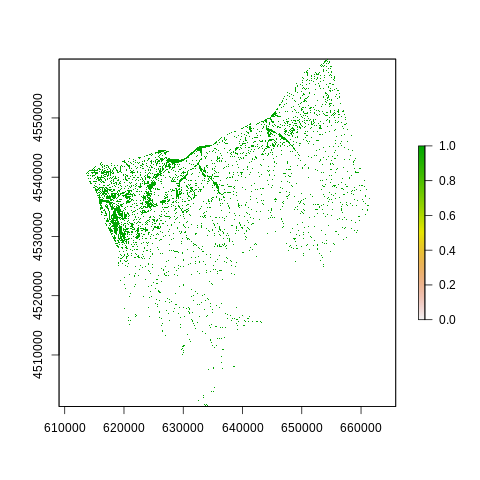

In [ ]:
##cek data slope_classified, yang 1 (hijau) memiliki kemiringan <= 10 derajat
%%R
plot(slope_classified)

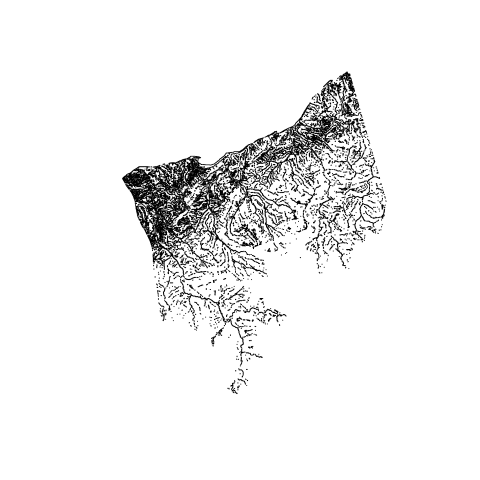

In [ ]:
##cek data r.to.poly
%%R
plot(r.to.poly)

In [ ]:
##read data polygon Landslides, kemudian transform
%%R
ls=readOGR("raw.shp")
ls <- spTransform(ls, CRS = CRS(proj4string(slope)))
writeOGR(ls, ".", "ls", driver="ESRI Shapefile")
ls

OGR data source with driver: ESRI Shapefile 
Source: "/content/drive/My Drive/Machine Learning with R/raw.shp", layer: "raw"
with 200 features
It has 3 fields
Integer64 fields read as strings:  ls 


R[write to console]: Error in writeOGR(ls, ".", "ls", driver = "ESRI Shapefile") : 
  layer exists, use a new layer name
Calls: <Anonymous> -> <Anonymous> -> withVisible -> writeOGR




Error in writeOGR(ls, ".", "ls", driver = "ESRI Shapefile") : 
  layer exists, use a new layer name
Calls: <Anonymous> -> <Anonymous> -> withVisible -> writeOGR


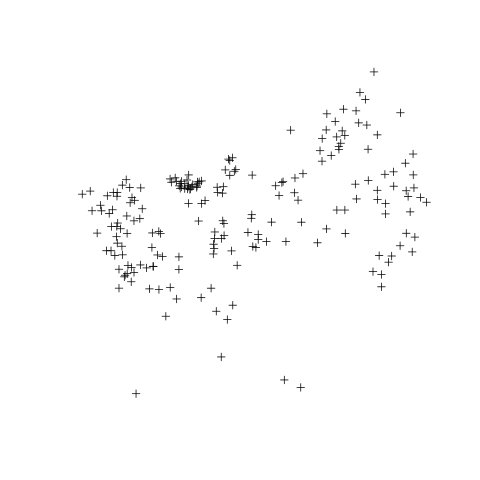

In [ ]:
##plot lokasi longsor/landslides
%%R
plot(ls)

In [ ]:
##membuat data no landslide, lokasi dimana tidak ada longsor
%%R
no.ls<-spsample(r.to.poly,n=100,"random") ##enambahkan titik2 random berdasarkan kemiringan <10
no.ls <- spTransform(no.ls, CRS = CRS(proj4string(slope)))
no.ls.spdf <- as(no.ls,"SpatialPointsDataFrame") ##diubah ke spatial point dataframe agar bisa disimpan ke csv
df <- as.data.frame(no.ls.spdf@coords)
write.csv(df, file="no_ls.csv")

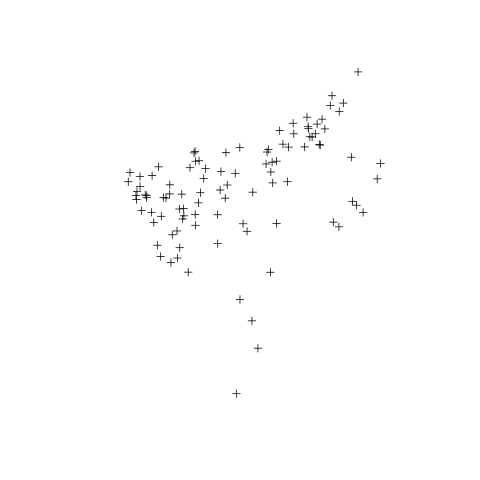

In [ ]:
##plot lokasi no landslides
%%R
plot(no.ls)

In [ ]:
#create merged raster sebagai data x
#load raster
%%R
slope <- raster("slope.tif")
ndvi <- raster("ndvi.tif")
landcover <- raster("landcover.tif")
elevation <- raster("elevation.tif")
curvature <- raster("curvature.tif")
#merged raster
a <- c('slope.tif', 'ndvi.tif', 'landcover.tif', 'elevation.tif','curvature.tif')
e <- extent(slope)
template <- raster(e) ##raster yang ukurannya mengikuti extent(slope)
proj4string(template) <- CRS('+init=epsg:23037')  ##assign proyeksi/CRS
writeRaster(template, file="merged.tif", format="GTiff", overwrite=TRUE)
mosaic_rasters(gdalfile=a,dst_dataset="merged.tif",of="GTiff",separate=TRUE)

[1] "slope.tif"     "ndvi.tif"      "landcover.tif" "elevation.tif"
[5] "curvature.tif"
NULL


# 2. Modeling Data

In [ ]:
## Load data
%%R
rasstack=stack("merged.tif") ##data X
point=readOGR("raw.shp") ##data Y, 1 = no ls, 2 = ls
rasvalue=extract(rasstack,point)
combined=cbind(point,rasvalue)
head(combined)
colnames(combined@data)[3] = "class"
colnames(combined@data)[4] = "B1"
colnames(combined@data)[5] = "B2"
colnames(combined@data)[6] = "B3"
colnames(combined@data)[7] = "B4"
colnames(combined@data)[8] = "B5"
head(combined)

OGR data source with driver: ESRI Shapefile 
Source: "/content/drive/My Drive/Machine Learning with R/raw.shp", layer: "raw"
with 200 features
It has 3 fields
Integer64 fields read as strings:  ls 
         x       y class        B1        B2 B3  B4      B5
1 616303.0 4539144     2 12.891417 0.4451340 21 131  0.1250
2 616435.3 4538430     2  9.043365 0.4972077  2 266  0.1875
3 617440.7 4538086     2 11.163626 0.4924292 21 224  0.0625
4 617864.1 4538562     2 13.557032 0.4856501 21 275 -0.0625
5 618446.2 4540308     2 18.165186 0.4285461 21 372 -0.0625
6 618472.6 4540784     2 25.791437 0.4180773 21 302 -0.6250


In [ ]:
##cek jumlah data per kelas/label
%%R
print(dim(combined))
combined@data %>%
  group_by(class) %>%
  summarise(
          count = n()
            )

[1] 200   8


R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 2 x 2
  class count
  <chr> <int>
1 1       100
2 2       100


In [ ]:
##Data Cleansing dan transformation
%%R
val=combined@data
val <- na.omit(val) ##membuang data NA
val=val[sample(nrow(val)),] ##mengacak data agar train tes split merata
val$class = as.factor(val$class) ##kolom class diubah menjadi faktor
print(dim(val))
head(val)

[1] 199   8
           x       y class         B1        B2 B3   B4      B5
45  635750.8 4537465     2 23.3630905 0.3108547 40  211  1.1250
175 629333.7 4539352     1  8.3723402 0.1584675 21  115  0.0625
150 625286.7 4542536     1  3.5763345 0.4566170 23  222  0.1250
192 642123.8 4515671     1  0.3580939 0.3770723 23 1418  0.7500
136 631878.7 4519598     1  5.8528113 0.3814976 25  808 -1.0625
179 622944.7 4533703     1 11.6746378 0.5200591 21  335  1.1250


In [ ]:
## Train-tes split dengan proporsi 80%-20%
%%R
N_FILES=199
SPLT=0.8 #80% train
b = floor(SPLT*N_FILES)
train = val[1:b,]
test = val[(b+1):N_FILES,]
cat("train = ", dim(train), "\n")
cat("test = ", dim(test), "\n")

train =  159 8 
test =  40 8 


In [ ]:
## Modeling dengan data train
%%R
modFit_rf <- caret::train(class ~ B1+B2+B3+B4+B5, method = "rf", data=train)
modFit_rf

Random Forest 

159 samples
  5 predictor
  2 classes: '1', '2' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 159, 159, 159, 159, 159, 159, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8265073  0.6523941
  3     0.8187955  0.6367880
  5     0.7961853  0.5917302

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [ ]:
##validasi dengan data test
%%R
validation_result<-predict(modFit_rf,newdata=test)
result_comparison<-cbind(as.numeric(as.character(validation_result)),test[,3])
preds<-result_comparison[,1]
y<-result_comparison[,2]
confmat <- confusionMatrix(as.factor(y),as.factor(preds), positive='2')
confmat

Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 15  2
         2  4 19
                                          
               Accuracy : 0.85            
                 95% CI : (0.7016, 0.9429)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 1.648e-05       
                                          
                  Kappa : 0.6977          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9048          
            Specificity : 0.7895          
         Pos Pred Value : 0.8261          
         Neg Pred Value : 0.8824          
             Prevalence : 0.5250          
         Detection Rate : 0.4750          
   Detection Prevalence : 0.5750          
      Balanced Accuracy : 0.8471          
                                          
       'Positive' Class : 2               
                                    

R[write to console]: Setting direction: controls < cases




Call:
roc.default(response = preds, predictor = y, levels = c("1",     "2"))

Data: y in 19 controls (preds 1) < 21 cases (preds 2).
Area under the curve: 0.8471


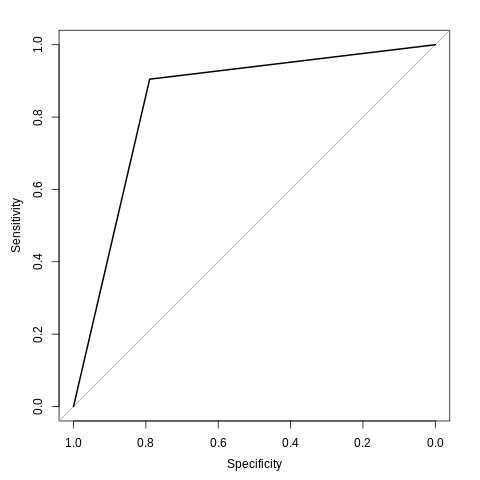

In [ ]:
##Kurva ROC
%%R
library(pROC)
kurva_roc<-roc(preds, y, levels=c("1", "2"))
print(kurva_roc)
plot(kurva_roc)

In [ ]:
##mempersiapkan data untuk prediksi
%%R
img_subset <- brick("merged.tif")
names(img_subset) <- c(paste0("B", 1:5, coll = ""))

R[write to console]: 2 cores detected, using 1



           used  (Mb) gc trigger  (Mb) max used   (Mb)
Ncells  3909559 208.8   11462920 612.2 25943617 1385.6
Vcells 11918131  91.0   36224451 276.4 46700853  356.3


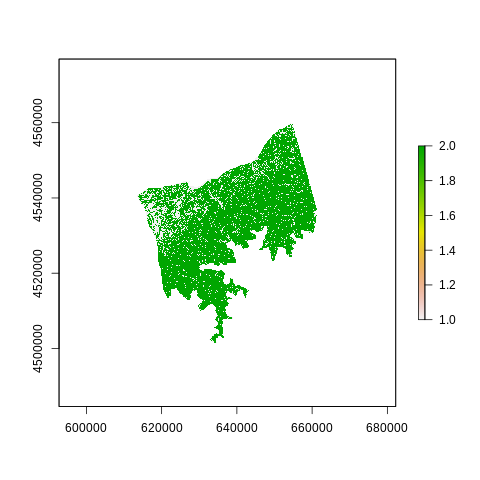

In [ ]:
##melakukan prediksi (1= no ls, 2 = ls)
%%R
#image prediction and write image
beginCluster()
preds_rf <- clusterR(img_subset, raster::predict, args = list(model = modFit_rf))
endCluster()
plot(preds_rf)
writeRaster(preds_rf, "rf_result_ls_pred", format = "GTiff", overwrite=TRUE)
gc()